# Business Understanding

# Data Understanding

## Importing data

In [1]:
# import all necessary libraries for use in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import sqlite3
import re

There are 8 SQL tables, 3 csv files, and 2 tsv files.

In [2]:
# import SQL tables as dataframes

conn = sqlite3.connect("data/im.db")

movie_basics_df = pd.read_sql("""
SELECT *
FROM movie_basics
;""", conn)

directors_df = pd.read_sql("""
SELECT *
FROM directors
;""", conn)

known_for_df = pd.read_sql("""
SELECT *
FROM known_for
;""", conn)

movie_akas_df = pd.read_sql("""
SELECT *
FROM movie_akas
;""", conn)

movie_ratings_df = pd.read_sql("""
SELECT *
FROM movie_ratings
;""", conn)

persons_df = pd.read_sql("""
SELECT *
FROM persons
;""", conn)

principals_df = pd.read_sql("""
SELECT *
FROM principals
;""", conn)

writers_df = pd.read_sql("""
SELECT *
FROM writers
;""", conn)

conn.close()

In [3]:
# import tsv files as dataframes

rtm_old_df = pd.read_csv('data/rt.movie_info.tsv', delimiter='\t')
rtr_old_df = pd.read_csv('data/rt.reviews.tsv', delimiter='\t', encoding= 'unicode_escape')

# import csv files as dataframes

bom_df = pd.read_csv('data/bom.movie_gross.csv')
tmdb_df = pd.read_csv('data/tmdb.movies.csv')
tn_df = pd.read_csv('data/tn.movie_budgets.csv')

rtm_df = pd.read_csv('data/rotten_tomatoes_movies.csv')
rtr_df = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')

To better understand a given dataframe, we'll use a function called "assess" to summarize its duplicates, missing data, and data types.

In [4]:
# This function will show the number of records, number of duplicate records,
# column names, and number of missing items from each column

def assess(df):
    print(str(len(df)) + ' records.')
    print()
    if len(df) == len(df.drop_duplicates()):
        print('This dataframe contains no duplicates.')
    else:
        num = len(df) - len(df.drop_duplicates())
        print('This dataframe contains ' + str(num) + ' duplicates.')
    print()
    print('Columns, and their missing data:')
    print(df.isna().sum())
    print('Data types:')
    print(df.dtypes)

## Summary of resources

### IMDb • Movie Basics (movie_basics_df)

records: 146,144

period: 2010-2020

value addition: runtime, genres

issues: some 'original title' values missing, but all 'primary title' values are present

*this resource is linked to several other tables, as noted below*

### The Movie Database (tmdb_df)

records: 26,517

period: 1930-2020

value addition: 'popularity'

issues: this notion of popularity isn't well defined and may not be of much use

### Rotten Tomatoes • Movies (rtm_df)

records: 17,712

period: 1914-2020

value addition: MPAA rating (e.g. PG-13), critics rating, audience rating, runtime, genres

issues: many titles have parentheses, e.g. "Batman (1989)"

*NOTE: the rotten tomatoes files that were provided contained no titles; these files were obtained online and contain roughly 10 times as many records (and include titles)*

### The Numbers (tn_df)

records: 5,782

period: 1915-2020

value addition: grosses and budgets

issues: none

### Box Office Mojo (bom_df)

records: 3,387

period: 2010-2018

value addition: grosses

issues: many grosses are incomplete

## Additional resources

### IMDb-linked tables

persons (persons_df): 606,647 records linking individuals to acting/writing/directing roles in movies

directors (directors_df): associates 140,417 movies with 109,253 directors

writer (writers_df): associates 110,261 movies with 122,576 writers

principals (principals_df): associates 143,454 movies with various movie personnel and ranks their importance on a given movie

known for (known_for_df): associates 576,444 persons with 514,781 movies that they are primarily known for

AKAs (movie_akas_df): associates 122,302 movies with alternate titles

ratings (movie_ratings_df): ratings for 73,856 movies

### Rotten Tomatoes reviews (rtr_df)

records: 1,130,017 movie reviews

# Data Preparation

## Removing duplicates

In [5]:
directors_df.drop_duplicates(inplace=True)
writers_df.drop_duplicates(inplace=True)
rtr_df.drop_duplicates(inplace=True)

## Editing data

### renaming columns

This will help standardize some naming conventions across different dataframes.

In [6]:
movie_basics_df.rename(columns={
    'primary_title': 'title', 
    'start_year': 'year', 
    'runtime_minutes': 'runtime'
}, inplace=True)

tn_df.rename(columns={
    'movie': 'title',
    'production_budget': 'budget',
    'worldwide_gross': 'gross'
}, inplace=True)

rtm_df.rename(columns={
    'movie_title': 'title',
    'content_rating': 'MPAA',
    'directors': 'director'
}, inplace=True)

### dates and years

We need to standardize all the "years" data in order to better understand and compare the periods of record. This will also come in handy later when we need to evaluate "recent" phenomena related to a movie's director and possibly cast.

In [7]:
# Here we'll add year columns to the tables that lack them (and for which a year would be relevant).

tmdb_df['year'] = tmdb_df.release_date.map(lambda x: x[:4])
tn_df['year'] = tn_df.release_date.map(lambda x: x[-4:])
rtm_df['year'] = rtm_df['original_release_date'].apply(lambda x: str(x)[:4] if type(x) == str else 0)

In [8]:
# Then we'll recast those columns as integers

tmdb_df = tmdb_df.astype({'year': 'int64'})
tn_df = tn_df.astype({'year': 'int64'})
rtm_df = rtm_df.astype({'year': 'int64'})

# Note that missing year entries for rtm_df were set to 0

There are IMDb records for years later than 2020, which are evidently not records of movies that had actually been released. We can safely drop these records.

In [9]:
movie_basics_df.drop(movie_basics_df[movie_basics_df['year'] > 2020].index, inplace=True)

Now that we have data for the years of the records that we can interpret, we'll create plots that compare the number and periods of records side by side.

In [10]:
# this function will help generate a line graph showing how many records a resource has by year

def yr_plt(df):
    return df[(df['year'] > 0) & (df['year'] <= 2020)].groupby(['year']).count()['title']

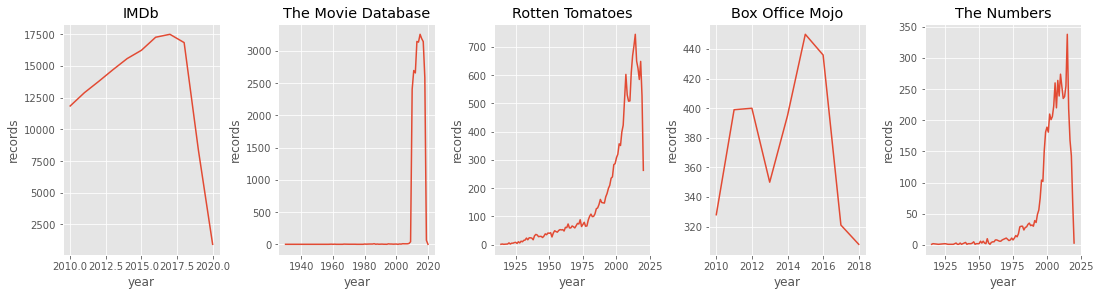

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

fig.set_figwidth(15)

ax1.plot(yr_plt(movie_basics_df))
ax1.set_xlabel('year')
ax1.set_ylabel('records')
ax1.set_title('IMDb')

ax2.plot(yr_plt(tmdb_df))
ax2.set_xlabel('year')
ax2.set_ylabel('records')
ax2.set_title('The Movie Database')

ax3.plot(yr_plt(rtm_df))
ax3.set_xlabel('year')
ax3.set_ylabel('records')
ax3.set_title('Rotten Tomatoes')

ax4.plot(yr_plt(bom_df))
ax4.set_xlabel('year')
ax4.set_ylabel('records')
ax4.set_title('Box Office Mojo')

ax5.plot(yr_plt(tn_df))
ax5.set_xlabel('year')
ax5.set_ylabel('records')
ax5.set_title('The Numbers')

fig.tight_layout(pad = 0.3)

plt.show()

It is apparent that we may largely need to limit exploration to the years 2010-2020. We can trim the years and make the comparison for just that period.

In [12]:
# this function will help generate a line graph showing how many records a resource has by year

def yr_plt(df):
    return df[(df['year'] > 2010) & (df['year'] <= 2020)].groupby(['year']).count()['title']

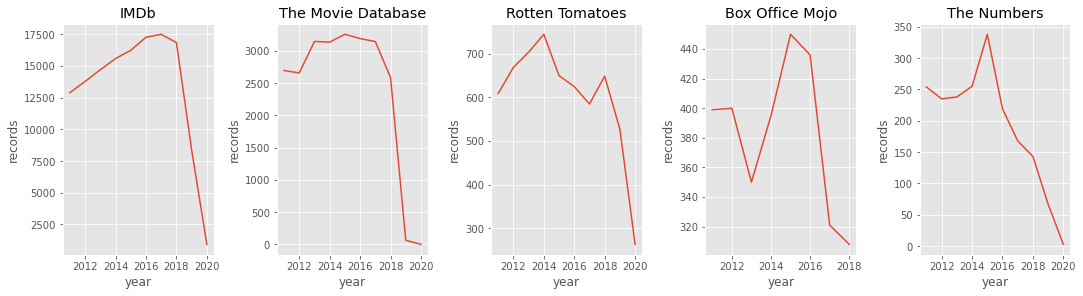

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

fig.set_figwidth(15)

ax1.plot(yr_plt(movie_basics_df))
ax1.set_xlabel('year')
ax1.set_ylabel('records')
ax1.set_title('IMDb')

ax2.plot(yr_plt(tmdb_df))
ax2.set_xlabel('year')
ax2.set_ylabel('records')
ax2.set_title('The Movie Database')

ax3.plot(yr_plt(rtm_df))
ax3.set_xlabel('year')
ax3.set_ylabel('records')
ax3.set_title('Rotten Tomatoes')

ax4.plot(yr_plt(bom_df))
ax4.set_xlabel('year')
ax4.set_ylabel('records')
ax4.set_title('Box Office Mojo')

ax5.plot(yr_plt(tn_df))
ax5.set_xlabel('year')
ax5.set_ylabel('records')
ax5.set_title('The Numbers')

fig.tight_layout(pad = 0.3)

plt.show()

### titles

Some Rotten Tomatoes records contain titles with parenthetical phrases that prevent them from matching other records.

In [14]:
rtm_df['title'] = rtm_df.title.map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

### budgets and grosses

Some of the records from Box Office Mojo are missing domestic, foreign, or both grosses. Since the only value that bom_df possibly adds is data involving grosses, we can safely drop these incomplete records.

In [15]:
bom_df.dropna(subset=['domestic_gross', 'foreign_gross'], inplace=True)

It is necessary to reformat all budget and gross values as integers

In [16]:
# This function will convert dollar amounts from strings to integers and resolve any other formatting issues

def dol_to_int(dol):
    if type(dol) == int:
        return dol
    if type(dol) == str:
        return int(round(float(dol.replace(',', '').replace('$', '')),0))
    if dol > 0:
        return int(round(dol,0))
    else:
        return 0

tn_df['budget'] = tn_df.budget.map(lambda x: dol_to_int(x))
tn_df['gross'] = tn_df.gross.map(lambda x: dol_to_int(x))

bom_df['domestic_gross'] = bom_df.domestic_gross.map(lambda x: dol_to_int(x))
bom_df['foreign_gross'] = bom_df.foreign_gross.map(lambda x: dol_to_int(x))

Here we will create a "gross" column for bom_df as well. It's not clear whether we'll be able to use any of these bom_df records, since we don' have budget data for those records. In case the total grosses become useful, we'll calculate them.

In [17]:
bom_df['gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']

We'll drop any records that have zeros as any of these values, as they must surely be inaccurate.

In [18]:
tn_df.drop(tn_df[tn_df['budget'] == 0].index, inplace=True)
tn_df.drop(tn_df[tn_df['gross'] == 0].index, inplace=True)
bom_df.drop(tn_df[tn_df['gross'] == 0].index, inplace=True)

## Feature creation

### convert budgets and grosses to 2020 dollars

This will be necessary to make comparisons valid across time.

In [19]:
# import a dataframe containing historical data about inflation
inflation_df = pd.read_csv('data/inflation_data.csv')

# this function will help generate a multiplier to correct dollar values for inflation to 2020 equivalent values
def inf(yr):
    return float(20.54 / inflation_df[inflation_df['year'] == yr]['amount'])

# update the relevant entries
tn_df['multiplier'] = tn_df.year.map(lambda x: inf(x))
tn_df['budget'] = tn_df['budget'] * tn_df['multiplier']
tn_df['gross'] = tn_df['gross'] * tn_df['multiplier']

bom_df['multiplier'] = bom_df.year.map(lambda x: inf(x))
bom_df['gross'] = bom_df['gross'] * bom_df['multiplier']

### profit and ROI

In [20]:
tn_df['profit'] = tn_df['gross'] - tn_df['budget']
tn_df['ROI'] = tn_df['gross'] / tn_df['budget']

In all explorations related to profit and ROI, we will be limited to movies which have these records from The Numbers. There are 5,415 such movies.

### runtime dataframe

We'll begin by joining records from The Numbers (which contain profit and ROI data) with records from IMDb (which contain runtime data).

In [21]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# select only records with nonzero runtime
df1 = movie_basics_df[movie_basics_df['runtime'] > 0].drop(['movie_id', 'original_title', 'genres'], axis=1)

# create joined dataframe
runtime_df_1 = df0.join(df1.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_imdb')

# trim dataframe to only records with matching years
runtime_df_1 = runtime_df_1[runtime_df_1['year_tn'] == runtime_df_1['year_imdb']]

# rename and trim unnecessary columns
runtime_df_1['year'] = runtime_df_1['year_tn']
runtime_df_1.drop(['year_imdb', 'year_tn'], axis=1, inplace=True)

# show how many records we've captured
runtime_df_1.count()['title']

1408

There are 1,408 records that IMDb has in common with The Numbers. The only other resource with runtime data is Rotten Tomatoes.

In [22]:
# prepare trimmed version of rtm_df
df2 = rtm_df[rtm_df['runtime'] > 0].drop(['rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'MPAA',
                                          'genres', 'director', 'authors', 'actors', 'original_release_date',
                                          'streaming_release_date', 'production_company', 'tomatometer_status',
                                          'tomatometer_rating', 'tomatometer_count', 'audience_status',
                                          'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
                                          'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'
                                         ], axis=1)


# create joined dataframe
runtime_df_2 = df0.join(df2.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_rtm')

# trim dataframe to only records with matching years
runtime_df_2 = runtime_df_2[runtime_df_2['year_tn'] == runtime_df_2['year_rtm']]

# rename and trim unnecessary columns
runtime_df_2['year'] = runtime_df_2['year_tn']
runtime_df_2.drop(['year_rtm', 'year_tn'], axis=1, inplace=True)

# show how many records we've captured
runtime_df_2.count()['title']

4012

In [23]:
# combine the dataframes
runtime_df = pd.concat([runtime_df_1, runtime_df_2])

# show how many records we've captured
runtime_df.count()['title']

5420

Rotten Tomatoes had 4,012 records that matched records from The Numbers. After combining both IMDb and Rotten Tomatoes runtime records, we had 5,420 records to inspect.

There can be multiple instances of the same title if the years also match. If multiple records have duplicated values in both names and years, then there are two possibilities:

1. The runtimes match, and we should keep the first value.
2. The runtimes *don't* match. In this case, we don't want to associate our quantitative results with false values, so we choose to keep none of the duplicated records.

In [24]:
runtime_df.drop_duplicates(subset=['title', 'year', 'runtime'], keep='first', inplace=True)
runtime_df.count()['title']

4697

In [25]:
runtime_df.drop_duplicates(subset=['title', 'year'], keep=False, inplace=True)
runtime_df.count()['title']

3691

In the end, we kept 3,691 records.

Next we can look at the general distribution of runtimes.

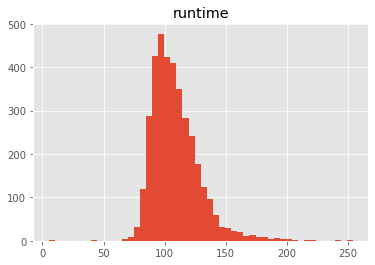

In [26]:
# look at the general distribution of runtimes
runtime_df.hist(column='runtime', bins=50);

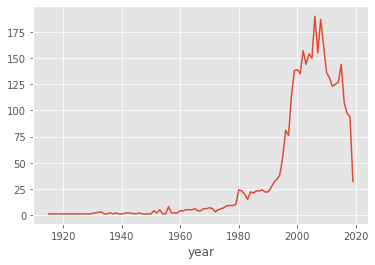

In [27]:
runtime_df.groupby(['year']).count()['title'].plot();

In [28]:
# find percentile values for a number of bins
num = 15
binp = []
for i in range(num):
    binp.append((i+1)/num)

# create bins based on percentiles
bins = []
for i in range(num+2):
    bins.append(runtime_df['runtime'].describe(percentiles=binp)[i+3])

# create new column by cutting into bins
runtime_df['runtime_bins'] = pd.cut(runtime_df['runtime'], bins)

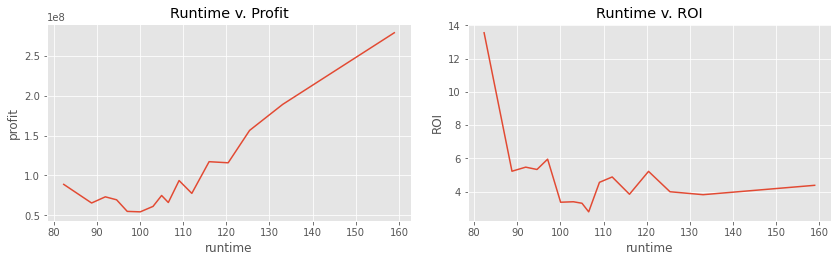

In [29]:
df = runtime_df.groupby('runtime_bins').mean()
x = df['runtime']
y1 = df['profit']
y2 = df['ROI']

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_figwidth(12)

ax1.plot(x,y1)
ax1.set_xlabel('runtime')
ax1.set_ylabel('profit')
ax1.set_title('Runtime v. Profit')

ax2.plot(x,y2)
ax2.set_xlabel('runtime')
ax2.set_ylabel('ROI')
ax2.set_title('Runtime v. ROI')

fig.tight_layout(pad = 2.0)

plt.show()

### genre dataframe

We'll join the records from The Numbers (which contain profit and ROI data) with records from IMDb and Rotten Tomatoes (which contain runtime data).

In [30]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# prepare trimmed version of movie_basics_df
df1 = movie_basics_df.drop(movie_basics_df[movie_basics_df['genres'].isna()].index)
df1['genres'] = df1.genres.map(lambda x: x.lower())
df1.drop(['movie_id', 'original_title', 'runtime'], axis=1, inplace=True)

# create joined dataframe
genre_df_1 = df0.join(df1.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_imdb')

# trim dataframe to only records with matching years
genre_df_1 = genre_df_1[genre_df_1['year_tn'] == genre_df_1['year_imdb']]

# rename and trim unnecessary columns
genre_df_1['year'] = genre_df_1['year_tn']
genre_df_1.drop(['year_imdb', 'year_tn'], axis=1, inplace=True)

# show how many records we've captured
genre_df_1.count()['title']

1418

In [31]:
# prepare trimmed version of rtm_df
df2 = rtm_df.drop(rtm_df[rtm_df['genres'].isna()].index)
df2['genres'] = df2.genres.map(lambda x: x.lower())
df2.drop(['rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'MPAA', 'runtime', 'director', 'authors',
          'actors', 'original_release_date', 'streaming_release_date', 'production_company', 'tomatometer_status',
          'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',
          'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'
         ], axis=1, inplace=True)

# create joined dataframe
genre_df_2 = df0.join(df2.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_rtm')

# trim dataframe to only records with matching years
genre_df_2 = genre_df_2[genre_df_2['year_tn'] == genre_df_2['year_rtm']]

# rename and trim unnecessary columns
genre_df_2['year'] = genre_df_2['year_tn']
genre_df_2.drop(['year_rtm', 'year_tn'], axis=1, inplace=True)

# show how many records we've captured
genre_df_2.count()['title']

4035

In [32]:
# combine the dataframes
genre_df = pd.concat([genre_df_1, genre_df_2])

# show how many records we've captured
genre_df.count()['title']

5453

The Numbers had 1,418 records in common with IMDb and 4,035 records in common with Rotten Tomatoes, totalling 5,453 when combined.

When we addressed duplicates in the runtime dataframe, we chose to discard ALL duplicated records where the runtimes differed. Since genres are subjective, however, it is more acceptable to just keep the first such record.

In [33]:
# drop duplicates for title and year; keep first record
genre_df.drop_duplicates(subset=['title', 'year'], keep='first', inplace=True)

# show how many records we've captured
genre_df.count()['title']

4197

In the end, we kept 4197 records.

### genre tags

It will take some effort to isolate single genres. First we need to generate a list of the genres and then standardize them, as IMDb and Rotten Tomatoes use different genre naming conventions.

In [34]:
genres = set()
for genre_list in genre_df['genres']:
    genre_list = genre_list.lower().split(',')
    for genre in genre_list:
        genres.add(genre.strip())
genres

{'action',
 'action & adventure',
 'adventure',
 'animation',
 'art house & international',
 'biography',
 'classics',
 'comedy',
 'crime',
 'cult movies',
 'documentary',
 'drama',
 'faith & spirituality',
 'family',
 'fantasy',
 'gay & lesbian',
 'history',
 'horror',
 'kids & family',
 'music',
 'musical',
 'musical & performing arts',
 'mystery',
 'mystery & suspense',
 'romance',
 'sci-fi',
 'science fiction & fantasy',
 'special interest',
 'sport',
 'sports & fitness',
 'television',
 'thriller',
 'war',
 'western'}

In [35]:
len(genres)

34

It will be of great help to standardize some of these 34 genre names. We will collapse "adventure" and "action" into one genre, and similarly collapse "mystery", "suspense" and "thriller", as well as a few others seen in the code below.

In [36]:
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('action & adventure', 'action'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('adventure', 'action'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('musical & performing arts', 'music'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('musical', 'music'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('mystery & suspense', 'suspense'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('mystery', 'suspense'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('thriller', 'suspense'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sci-fi & fantasy', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('science fiction & fantasy', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sci-fi', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('fantasy', 'sci-fi & fantasy'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('anime & manga', 'animation'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('kids & family', 'family'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sports & fitness', 'sport'))

genres = set()
for genre_list in genre_df['genres']:
    genre_list = genre_list.lower().split(',')
    for genre in genre_list:
        genres.add(genre.strip())

len(genres)

24

Now we'll explore the distribution of genres and genre-pairing.

In [37]:
genre_count = {}
genre_profit = {}
genre_ROI = {}

for genre in genres:
    genre_count[genre] = genre_df.genres.str.contains(genre).sum()
    genre_profit[genre] = int(round((genre_df.genres.str.contains(genre) * genre_df.profit).mean(),0))
    genre_ROI[genre] = round((genre_df.genres.str.contains(genre) * genre_df.ROI).mean(),2)

genre_count = sorted(genre_count.items(), key=lambda x: x[1])
genre_profit = sorted(genre_profit.items(), key=lambda x: x[1])
genre_ROI = sorted(genre_ROI.items(), key=lambda x: x[1])

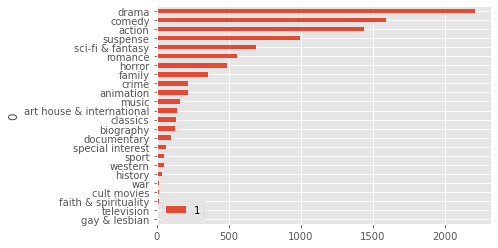

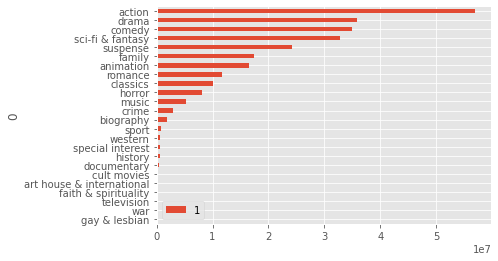

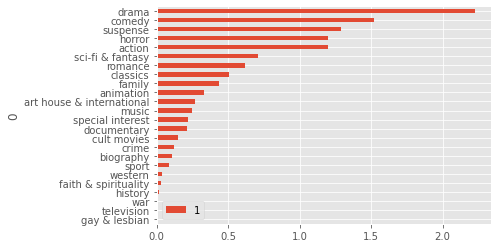

In [38]:
ax1 = pd.DataFrame(genre_count).plot.barh(x=0, y=1)
ax2 = pd.DataFrame(genre_profit).plot.barh(x=0, y=1)
ax3 = pd.DataFrame(genre_ROI).plot.barh(x=0, y=1)

### MPAA rating

In [39]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# prepare trimmed version of rtm_df
df1 = rtm_df.drop(rtm_df[rtm_df['MPAA'].isna()].index)
df1.drop(['rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'genres', 'runtime', 'director', 'authors',
          'actors', 'original_release_date', 'streaming_release_date', 'production_company', 'tomatometer_status',
          'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',
          'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'
         ], axis=1, inplace=True)

# create joined dataframe
rating_df = df0.join(df1.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_rtm')

# trim dataframe to only records with matching years
rating_df = rating_df[rating_df['year_tn'] == rating_df['year_rtm']]

# rename and trim unnecessary columns
rating_df['year'] = rating_df['year_tn']
rating_df.drop(['year_rtm', 'year_tn'], axis=1, inplace=True)

# show how many records we've captured
rating_df.count()['title']

4035

In [40]:
# drop duplicates for title and year; keep first record
rating_df.drop_duplicates(subset=['title', 'year'], keep='first', inplace=True)

# show how many records we've captured
rating_df.count()['title']

4034

In [41]:
ratings = set()
for rating in rating_df['MPAA']:
    ratings.add(rating)
ratings

{'G', 'NC17', 'NR', 'PG', 'PG-13', 'R'}

In [42]:
ratings_count = {}
ratings_profit = {}
ratings_ROI = {}

for rating in ratings:
    ratings_count[rating] = rating_df.MPAA.str.contains(rating).sum()
    ratings_profit[rating] = int(round((rating_df.MPAA.str.contains(rating) * rating_df.profit).mean(),0))
    ratings_ROI[rating] = round((rating_df.MPAA.str.contains(rating) * rating_df.ROI).mean(),2)

ratings_count = sorted(ratings_count.items(), key=lambda x: x[1])
ratings_profit = sorted(ratings_profit.items(), key=lambda x: x[1])
ratings_ROI = sorted(ratings_ROI.items(), key=lambda x: x[1])

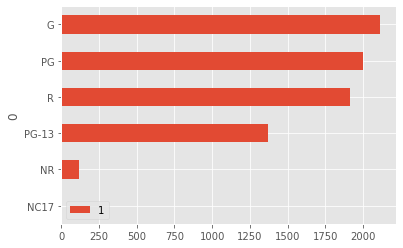

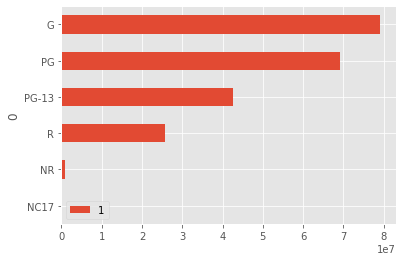

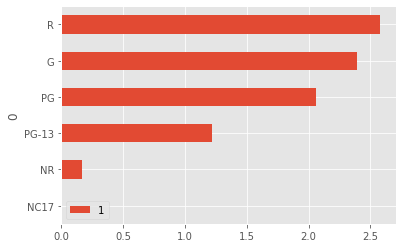

In [43]:
ax1 = pd.DataFrame(ratings_count).plot.barh(x=0, y=1)
ax2 = pd.DataFrame(ratings_profit).plot.barh(x=0, y=1)
ax3 = pd.DataFrame(ratings_ROI).plot.barh(x=0, y=1)

### past profit and ROI of director

In [59]:
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

df1 = movie_basics_df.drop(['original_title', 'runtime', 'genres'], axis=1)

dir_df = df0.join(df1.set_index('title'), on='title', how='inner', lsuffix='_tn', rsuffix='_imdb')

# trim dataframe to only records with matching years
dir_df = dir_df[dir_df['year_tn'] == dir_df['year_imdb']]

# rename and trim unnecessary columns
dir_df['year'] = dir_df['year_tn']
dir_df.drop(['year_imdb', 'year_tn'], axis=1, inplace=True)

dir_df = dir_df.join(directors_df.set_index('movie_id'), on='movie_id', how='inner')

dir_df = dir_df.join(persons_df.set_index('person_id'), on='person_id', how='inner')

dir_df.rename(columns={'primary_name': 'director'}, inplace=True)

dir_df.drop(['movie_id', 'person_id', 'birth_year', 'death_year', 'primary_profession'], axis=1, inplace=True)

dir_df['past profit'] = pp(dir_df['director'], dir_df['year'])

In [58]:
pp_len = 3

def pp(director, year):
    return dir_df[(dir_df['director'] == director) & (dir_df['year'] < year) & (dir_df['year'] > year - pp_len)]['profit'].mean()

In [60]:
dir_df['past profit'].max()

nan

one small change to see if it affects git

### "star power"

## Missing data

<< DISCUSS WHAT TO DO ABOUT MISSING DATA >>

# Recommendations

## Running time

## Genre

## Director experience

# Recap